In [157]:
import os
import math
import random
import datetime
from collections import defaultdict
from enum import Enum
import numpy as np 
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import Module
import gymnasium
from gymnasium import Env
from gymnasium.spaces.box import Box
from gymnasium.spaces.discrete import Discrete
from gymnasium.utils.env_checker import check_env
from typing import (
    Type,
    OrderedDict,
    List,
    Tuple,
    Callable,
)
import matplotlib.pyplot as plt
import stable_baselines3
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from torch.utils.tensorboard import SummaryWriter
import wandb

- See if there is transfer from learning regression models from a couple different sine curves to yet a different sine curve.
- We know there is transfer is (1) it takes less to train and (2) if the model chooses to reuse layers rather than create new ones.
- We first train regression models without the meta-learner (because the 'meta' ability cannot do anything without pre-trained weights).
- The meta-learner will then output actions to build a model for unseen data.
- Actions will be continuous, a vector of probabilities corresponding to which layer to add from the layer pool. One of these probabilities corresponds to adding no layer and just training the architecture as it is.

## config

In [158]:
default_config = {
    'seed' : 41,
    'device' : 'cuda',
    'epochs' : 5,
    'timesteps' : 200,
    'n_x' : 100,
    'n_tasks' : 3,
    'in_features' : 1,
    'out_features' : 1,
    'pool_n_layers' : 30,
    'n_layers_per_network' : 5,
    'n_nodes_per_layer' : 32,
    'pool_layer_type' : torch.nn.Linear,
    'action_space_shape' : (3,),
    'epsilon' : 0.1,
    'batch_size' : 1,
    'learning_rate' : 0.01,
    'action_cache_size' : 5,
    'num_workers' : 0,
    'loss_fn' : torch.nn.MSELoss(),
    'sb3_model' : 'RecurrentPPO',
    'sb3_policy' : 'MlpLstmPolicy',
    'log_dir' : 'log',
    }
config = default_config
config

{'seed': 41,
 'device': 'cuda',
 'epochs': 5,
 'timesteps': 200,
 'n_x': 100,
 'n_tasks': 3,
 'in_features': 1,
 'out_features': 1,
 'pool_n_layers': 30,
 'n_layers_per_network': 5,
 'n_nodes_per_layer': 32,
 'pool_layer_type': torch.nn.modules.linear.Linear,
 'action_space_shape': (3,),
 'epsilon': 0.1,
 'batch_size': 1,
 'learning_rate': 0.01,
 'action_cache_size': 5,
 'num_workers': 0,
 'loss_fn': MSELoss(),
 'sb3_model': 'RecurrentPPO',
 'sb3_policy': 'MlpLstmPolicy',
 'log_dir': 'log'}

In [159]:
wandb.init(
    project='reinforcement-meta-learning',
    config=config
)

loss_epoch0_task0,▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁█▄▁▃▁▁▁▁▁▁▁▁▁▁▁▂▃▁▁▁
loss_epoch0_task1,▁▄▆▁▂▂▁▂▃▂▁▃▁▂▃▁▃▂▄▂▂█▁▅▄▇▄▁▂▁▇▂▃▁▁▃▂▁▃▂
loss_epoch0_task2,▅▁▁▁▁▂▁▂▂▃▂▂▁▂▁▁▁▃█▁▁▃▁▁▅▂▁▁▃▁▁▁▂▄▁▁▁▂▁▁
loss_epoch1_task0,▂█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_epoch1_task1,▂▁▃▁▂█▁▂▁▁▂▆▄▁▁▂▁▂▂▁▂▁▁▂▃▃▃▂▃▂▁▆▁▅▁▃▂▂▁▆
loss_epoch1_task2,▃▁▄▁▃▃▂▄▂▄▁▁▄▂▄▁▃▁▂▃▂▁▁▁▁▂▁▁▂▂▁▁▁█▁▁▂▁▄▃
loss_epoch2_task0,█▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
loss_epoch2_task1,▄▃▂▂▂▅▁▄▃▁▁▃▆▃▄▇▃▃▄▂▅▁▃▁▁▁▂▅█▂▁▅▆▃▃▇▅▁▄▄
loss_epoch2_task2,▅▁▁▁▁▂▁▃▁▂▁▂▁▁▁▁▁▇▁▁▁▁▁▂▆▂▁█▁▁▁▂▁▁▁▁▁▁▁▁
loss_epoch3_task0,▁▃▁▂▁▁▁▁▁▁▁▁▂▃▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_epoch3_task1,█▃▄▁▃▂▁▂▁▃▃▃▂▄▁▂▁▁▃▁▄▁▄▁▂▄▁▂▁▁▃▁▂▁▁▁▄▃▂▂


In [121]:
torch.cuda.is_available()

True

## Reinforcement Meta-Learning (REML) / "Learning to Learn by Gradient Descent as a Markov Decision Process"

- layer pool
- inner network -- composed of layers from layer pool
- outer network (meta learner) -- responsible for parameters and hyperparameters of inner network

### sinusoidal curve regression as in MAML 2018 paper

In [122]:
lower_bound = torch.tensor(-5).float()
upper_bound = torch.tensor(5).float()
X = np.linspace(lower_bound, upper_bound, config['n_x'])
amplitude_range = torch.tensor([0.1, 5.0]).float()
phase_range = torch.tensor([0, math.pi]).float()
amps = torch.from_numpy(np.linspace(amplitude_range[0], amplitude_range[1], config['n_tasks'])).float()
phases = torch.from_numpy(np.linspace(phase_range[0], phase_range[1], config['n_tasks'])).float()
tasks_data = torch.tensor(np.array([ 
        X
        for _ in range(config['n_tasks'])
        ])).float()
tasks_targets = torch.tensor(np.array([
        [((a * np.sin(x)) + p).float()
        for x in X] 
        for a, p in zip(amps, phases)
        ])).float()
tasks_info = [
        [{'i' : i, 
         'amp' : a, 
         'phase_shift' : p, 
         'lower_bound' : lower_bound, 
         'upper_bound' : upper_bound, 
         'amplitude_range_lower_bound' : amplitude_range[0], 
         'amplitude_range_upper_bound' : amplitude_range[1], 
         'phase_range_lower_bound' : phase_range[0],
         'phase_range_lower_bound' : phase_range[1]}
         for _ in X]
        for i, (a, p) in enumerate(zip(amps, phases))
]
print(f'[INFO] Tasks created.')

[INFO] Tasks created.


In [123]:
print(tasks_data.shape)
print(tasks_data.dtype)
print(tasks_targets.shape)
print(tasks_targets.dtype)
print(len(tasks_info))
print(len(tasks_info[0]))

torch.Size([3, 100])
torch.float32
torch.Size([3, 100])
torch.float32
3
100


In [124]:
class RegressionModel(torch.nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(1, 32),  
            torch.nn.Linear(32, 32), 
            torch.nn.Linear(32, 32),  
            torch.nn.Linear(32, 32),  
            torch.nn.Linear(32, 1)  
        ])

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = torch.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x



{'seed': 41, 'device': 'cuda', 'epochs': 5, 'timesteps': 200, 'n_x': 100, 'n_tasks': 3, 'in_features': 1, 'out_features': 1, 'pool_n_layers': 30, 'n_layers_per_network': 5, 'n_nodes_per_layer': 32, 'pool_layer_type': <class 'torch.nn.modules.linear.Linear'>, 'action_space_shape': (3,), 'epsilon': 0.1, 'batch_size': 1, 'learning_rate': 0.01, 'action_cache_size': 5, 'num_workers': 0, 'loss_fn': MSELoss(), 'sb3_model': 'RecurrentPPO', 'sb3_policy': 'MlpLstmPolicy', 'log_dir': 'log'}

3
2


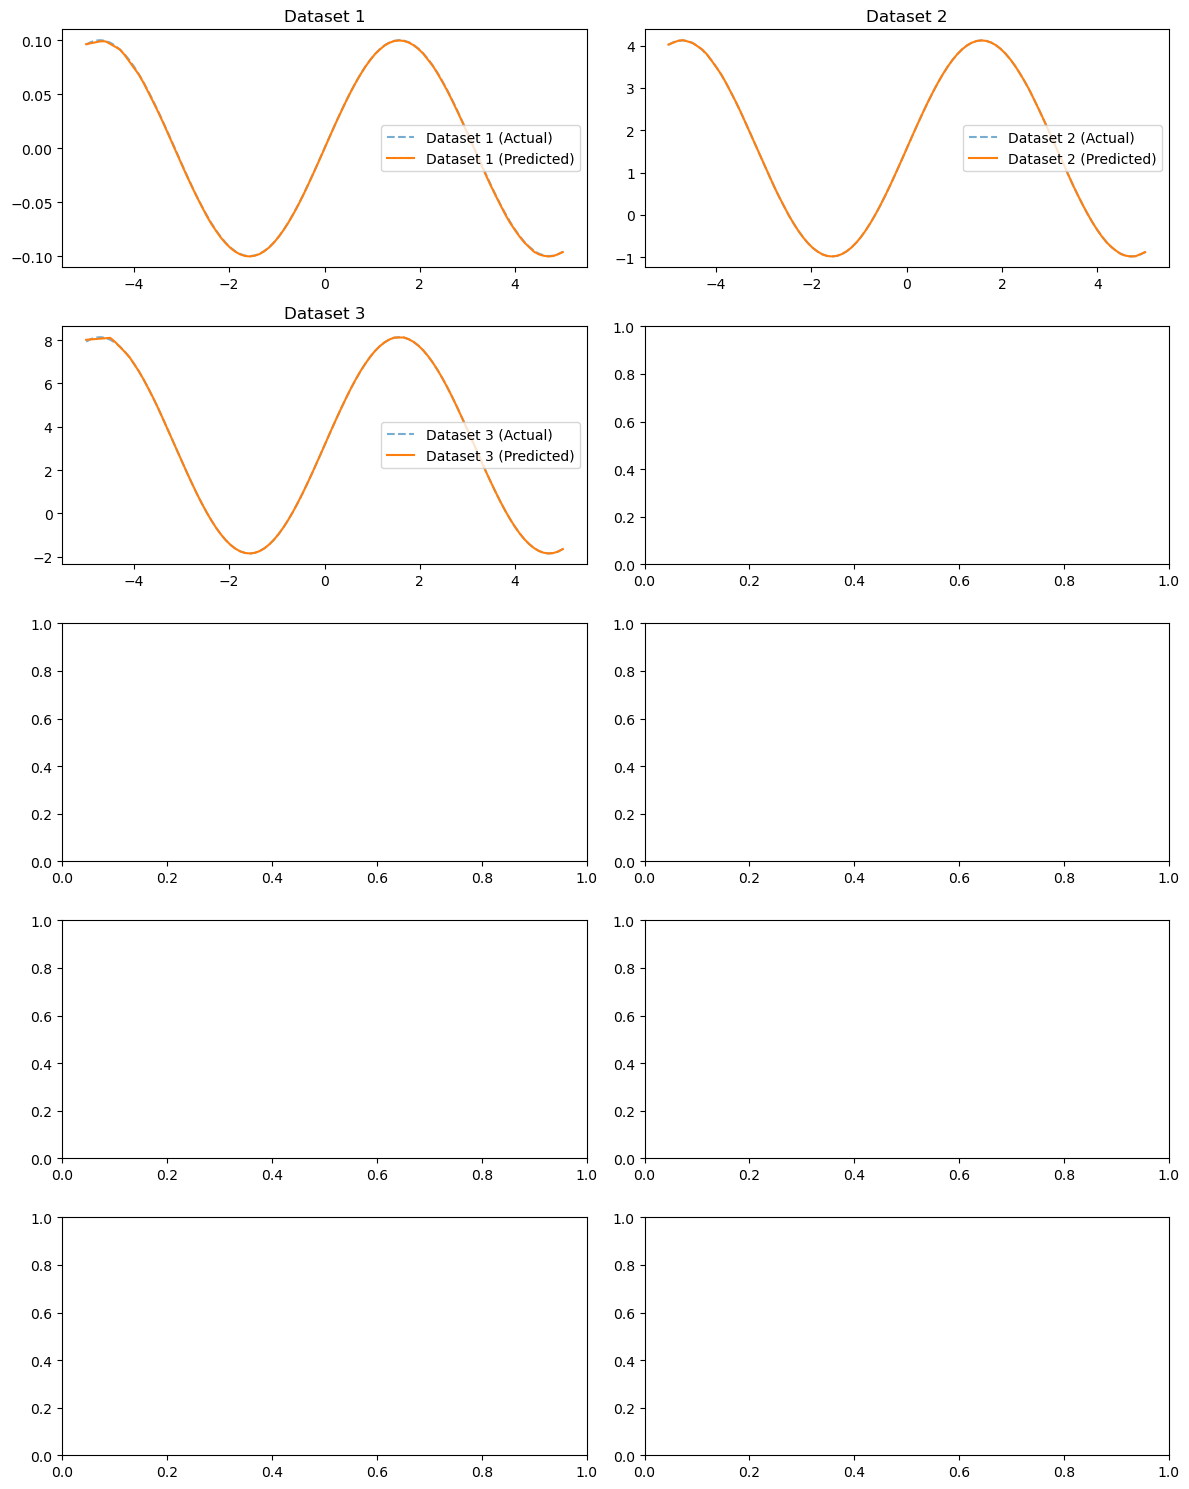

In [125]:
layers = []
data = []
for x, y in zip(tasks_data, tasks_targets):
    data.append([x,y])
print(config)
print()
print(len(data))
print(len(data[0]))
fig, axs = plt.subplots(5, 2, figsize=(12, 15))
for i, (x, y) in enumerate(data):
    model = RegressionModel()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # train before graphing
    num_epochs = 20000
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad() 
        outputs = model(x.view(-1, 1))
        loss = criterion(outputs, y.view(-1,1))
        loss.backward()
        optimizer.step()
    
    # get predicitons to graph
    model.eval()
    with torch.no_grad():
        outputs = model(x.view(-1, 1))
        test_loss = criterion(outputs, y.view(-1, 1))

    # graph truth vs. predictions
    row = i // 2
    col = i % 2
    axs[row, col].plot(x, y, label=f'Dataset {i + 1} (Actual)', linestyle='--', alpha=0.6)
    axs[row, col].plot(x, outputs.numpy(), label=f'Dataset {i + 1} (Predicted)')
    axs[row, col].set_title(f'Dataset {i + 1}')
    axs[row, col].legend()

    # save layers for layer pool
    layers.extend(model.layers)

plt.tight_layout()
plt.show()

In [126]:
print(f'Layers saved: n={len(layers)}, layers={layers}')

Layers saved: n=15, layers=[Linear(in_features=1, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=1, bias=True), Linear(in_features=1, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=1, bias=True), Linear(in_features=1, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=32, bias=True), Linear(in_features=32, out_features=1, bias=True)]


In [127]:
class Layer:
    def __init__(self, 
                params: Type[torch.nn.Linear]=config['pool_layer_type']):
        self.params = params
        self.used = False
        self.times_used = 0

class LayerPool:
    # pool of uniform Layer objects each with the same type and shape
    def __init__(self, 
                size: int=config['pool_n_layers'], 
                layer_type: Type[torch.nn.Linear]=config['pool_layer_type'],
                in_features: int=config['in_features'],
                out_features: int=config['out_features'],
                num_nodes_per_layer: int=config['n_nodes_per_layer'],
                layers: List[torch.nn.Linear]=None):
        self.size = size if layers is None else len(layers)
        self.layer_type = layer_type
        self.in_features = in_features
        self.out_features = out_features
        self.num_nodes_per_layer = num_nodes_per_layer

        # if no layers are passed, create and initialize layer pool from scratch
        if layers is None:
            self.layers = [Layer(params=self.layer_type(in_features=num_nodes_per_layer, out_features=num_nodes_per_layer))
                for _ in range(size)]
            for i in range(config['n_tasks']):
                self.layers[size + i] = self.layer_type(in_features=in_features, out_features=num_nodes_per_layer)
            for i in range(config['n_tasks']):
                self.layers[size + i] = self.layer_type(in_features=num_nodes_per_layer, out_features=out_features)
            [torch.nn.init.xavier_uniform_(layer.params.weight) for layer in self.layers.values()]
        else:
            self.layers = [Layer(params=layer) for layer in layers]
            config['pool_n_layers'] = len(self.layers)
        
    def __str__(self):
        return f"LayerPool(size={self.size}, layer_type={config['pool_layer_type']}, num_nodes_per_layer={config['n_nodes_per_layer']}"


In [128]:
class InnerNetworkAction(Enum):
    TRAIN = 0
    ADDTRAIN= 1
    DELETETRAIN = 2
    ERROR = 3

In [129]:
class InnerNetworkTask(Dataset):
    def __init__(self, data, targets, info):
        self.data = data 
        self.targets = targets
        self.info = info

    def __len__(self):
        assert len(self.data) == config['n_x'], '[ERROR] Length should be the same as N_X.'
        return len(self.data)

    def __getitem__(self, index):
        assert self.data[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.data[index].dtype}'
        assert self.targets[index].dtype == torch.float32, f'[ERROR] Expected type torch.float32, got type: {self.targets[index].dtype}'
        sample = {
            'x' : self.data[index],
            'y' : self.targets[index],
            'info' : self.info[index]
        }
        return sample
    
    def __str__(self):
        return f'[INFO] InnerNetworkTask(data={self.data, self.targets}, info={self.info})'

In [164]:
class InnerNetwork(gymnasium.Env, Module):
    def __init__(self, 
                epoch: int,
                task: InnerNetworkTask,
                layer_pool: LayerPool,
                in_features: int=config['in_features'],
                out_features: int=config['out_features'],
                learning_rate: float=config['learning_rate'],
                batch_size: int=config['batch_size'],
                epsilon: float=config['epsilon'],
                action_cache_size: float=config['action_cache_size'],
                num_workers: int=config['num_workers'],
                shuffle: bool=True,
                log_dir: str='runs',
                ):
        super(InnerNetwork, self).__init__()
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.layer_pool = layer_pool
        self.task = task
        self.in_features = in_features
        self.out_features = out_features
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.action_cache_size = action_cache_size
        self.num_workers = num_workers
        self.prev = defaultdict(lambda: None)
        self.curr = defaultdict(lambda: None)
        self.data_loader = DataLoader(task, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        self.data_iter = iter(self.data_loader)
        self.initial_layer = random.choice([layer for layer in self.layer_pool.layers if getattr(layer.params, 'in_features', None) == in_features])
        self.final_layer = random.choice([layer for layer in self.layer_pool.layers if getattr(layer.params, 'out_features', None) == out_features])
        self.layers = torch.nn.ModuleList([self.initial_layer.params, self.final_layer.params]) 
        self.layer_indices = [[layer.params for layer in self.layer_pool.layers].index(layer) for layer in self.layers] 
        self.loss_fn = torch.nn.MSELoss()
        self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate)
        self.actions_taken = [InnerNetworkAction.TRAIN] * config['action_cache_size']
        self.writer = SummaryWriter(log_dir=log_dir)
        self.state = self.reset()
        state_shape = self.build_state().shape
        self.observation_space = gymnasium.spaces.box.Box(low=float('-inf'), high=float('inf'), shape=state_shape)
        self.action_space = gymnasium.spaces.discrete.Discrete(self.layer_pool.size * 3)
        self.timestep = 0

    def step(self, action: np.int64) -> Tuple[torch.Tensor, float, bool, dict]: 
        assert action.shape == (), f'[ERROR] Expected action shape () for scalar {self.action_space.n}, got: {action.shape}'
        assert action.dtype == np.int64, f'[ERROR] Expected np.int64 dtype, got: {action.dtype}'

        self.timestep += 1
        self.train()
        self.next_batch()
        
        self.update_inner_network(action)
        self.run_inner_network()
        s_prime = self.build_state()
        reward = self.reward()
        self.log()

        return (
            s_prime,
            reward, 
            False,
            False,
            {}
        )
    
    def decide_action_type(self, action: np.int64) -> None:
        # limited network depth
        # each layer can only be used once
        # can only delete layers that exist
        if random.random() < self.epsilon: 
            action = random.randint(0, self.action_space.n - 1)
        add_action_type = action < self.layer_pool.size
        delete_action_type = action >= self.layer_pool.size and (action < self.layer_pool.size * 2)
        if (add_action_type):
            if (len(self.layers)==config['n_layers_per_network']):
                self.curr['action_type'] = InnerNetworkAction.ERROR
            # elif (self.layer_pool.layers[action] in self.layers):
            #     self.curr['action_type'] = InnerNetworkAction.ERROR
            elif self.layer_pool.layers[action].params.in_features==self.in_features or self.layer_pool.layers[action].params.out_features==self.out_features:
                self.curr['action_type'] = InnerNetworkAction.ERROR
            else:
                self.curr['action_type'] = InnerNetworkAction.ADDTRAIN
        elif (delete_action_type):
            action = action - self.layer_pool.size
            if (self.layer_pool.layers[action].params not in self.layers):
                self.curr['action_type'] = InnerNetworkAction.ERROR
            elif self.layer_pool.layers[action].params.in_features==self.in_features or self.layer_pool.layers[action].params.out_features==self.out_features:
                self.curr['action_type'] = InnerNetworkAction.ERROR
            else:
                self.curr['action_type'] = InnerNetworkAction.DELETETRAIN
        else:
            self.curr['action_type'] = InnerNetworkAction.TRAIN
        self.actions_taken.append(self.curr['action_type']) 
        return action 
    
    def update_inner_network(self, action: np.int64) -> None:
        index = self.decide_action_type(action)
        if (self.curr['action_type']==InnerNetworkAction.ADDTRAIN): 
            new_layer = self.layer_pool.layers[index].params
            # # new initial layer
            # if new_layer.in_features==self.in_features:
            #     self.layers.pop(0) 
            #     self.layers.insert(0, new_layer)
            # # new final layer
            # elif new_layer.out_features==self.out_features:
            #     self.layers.pop(-1)
            #     self.layers.append(new_layer)
            final_layer = self.layers.pop(-1) 
            self.layers.append(new_layer)
            self.layers.append(final_layer) 
        elif (self.curr['action_type']==InnerNetworkAction.DELETETRAIN):
            layers_copy = self.layers
            self.layers = torch.nn.ModuleList([layer for layer in self.layers if layer!=self.layer_pool.layers[index].params])
            assert len(layers_copy)!=len(self.layers), '[ERROR] Delete on inner network failed.'
        elif (self.curr['action_type']==InnerNetworkAction.TRAIN or self.curr['action_type']==InnerNetworkAction.ERROR):
            return 
        else: 
            raise Exception(f"[ERROR] Unexpected action returned by inner network: {self.curr['action_type']}")
        self.layer_indices = [[layer.params for layer in self.layer_pool.layers].index(layer) for layer in self.layers] 
            
    def next_batch(self, throw_exception=False) -> None:
        self.prev = self.curr
        self.curr = defaultdict(lambda: None)

        if (throw_exception):
            batch = next(self.data_iter)
            self.curr['x'] = batch['x']
            self.curr['y'] = batch['y'] 
            self.curr['info'] = batch['info']
        else: 
            try:
                batch = next(self.data_iter)
            except StopIteration:
                self.data_loader = DataLoader(self.task, batch_size=self.batch_size, shuffle=self.shuffle, num_workers=self.num_workers)
                self.data_iter = iter(self.data_loader)
                batch = next(self.data_iter)
            finally:
                self.curr['x'] = batch['x']
                self.curr['y'] = batch['y'] 
                self.curr['info'] = batch['info']
    
    def run_inner_network(self) -> None: 
        if self.training:
            self.opt = torch.optim.Adam(self.layers.parameters(), lr=self.learning_rate) 
            self.opt.zero_grad()
            self.forward(self.curr['x'])
            loss = self.curr['loss']
            loss.backward()
            self.opt.step()
        else:
            self.forward(self.curr['x'])

    def forward(self, x) -> None:
        for i in range(len(self.layers) - 1): 
            x = torch.nn.functional.relu(self.layers[i](x))
        self.curr['latent_space'] = x
        self.curr['y_hat'] = self.layers[-1](x) 
        self.curr['prev_loss'] = self.curr['loss']
        self.curr['loss'] = self.loss_fn(self.curr['y'], self.curr['y_hat'])
        assert self.curr['latent_space'].dtype == torch.float32
        assert self.curr['y_hat'].dtype == torch.float32

    def build_state(self) -> np.ndarray:
        one_hot_network_layers = torch.tensor(np.array([1 if self.layer_pool.layers[i].params in self.layers else 0 
                                   for i in range(len(self.layer_pool.layers))]))
        num_add_actions = torch.tensor(len(list(filter(lambda e : e == InnerNetworkAction.ADDTRAIN, self.actions_taken)))).unsqueeze(0)
        num_delete_actions = torch.tensor(len(list(filter(lambda e : e == InnerNetworkAction.DELETETRAIN, self.actions_taken)))).unsqueeze(0)
        num_layers = torch.tensor(len(self.layers)).unsqueeze(0)
        h = torch.tensor([action_enum.value for action_enum in self.actions_taken[-self.action_cache_size:]])
        task_info = torch.tensor([float(value) for value in self.curr['info'].values()])

        # sequence_network_layers = torch.tensor(np.array([index + 1 for index in self.pool_indices] + [0] * (self.layer_pool.size - len(self.pool_indices))))

        return torch.concat((
            # about the task
            task_info,
            self.curr['x'],
            # about the inner network's choices
            self.curr['latent_space'],
            self.curr['y'],
            self.curr['y_hat'],
            # about the meta network's choices
            one_hot_network_layers,
            num_add_actions,
            num_delete_actions,
            num_layers,
            h
        ), dim=0).detach().numpy()
    
    def reward(self) -> torch.Tensor:
        prev_loss = self.curr['prev_loss'] or None
        curr_loss = self.curr['loss']
        loss_delta = prev_loss - curr_loss if prev_loss is not None else curr_loss
        if (self.curr['action_type'] == InnerNetworkAction.ADDTRAIN):
            reward = loss_delta / math.sqrt(len(self.layers))
        elif (self.curr['action_type'] == InnerNetworkAction.DELETETRAIN or self.curr['action_type'] == InnerNetworkAction.TRAIN):
            reward = loss_delta
        elif (self.curr['action_type'] == InnerNetworkAction.ERROR):
            reward = -1
        else:
            raise Exception('[ERROR] Invalid action type.')
        self.curr['reward'] = reward
        return reward

    def log(self):
        task_num = str(self.curr['info']['i'].item())
        self.writer.add_scalar(f'loss_epoch{self.epoch}_task{task_num}', self.curr['loss'], global_step=self.timestep) 
        wandb.log({ f'loss_epoch{self.epoch}_task{task_num}' : self.curr['loss'] })
        # self.writer.add_scalar(f'num_layers_epoch{self.epoch}_task{task_num}', len(self.layers), global_step=self.timestep) 
        self.writer.add_scalar(f'reward_epoch{self.epoch}_task{task_num}', self.curr['reward'], global_step=self.timestep)
        wandb.log({ f'reward_epoch{self.epoch}_task{task_num}' : self.curr['reward'], })
        if (len(self.layers)!=0):
            self.writer.add_histogram(f'pool_indices_epoch{self.epoch}_task{task_num}', torch.tensor(self.layer_indices).long(), global_step=self.timestep) 
            wandb.log({ f'pool_indices_epoch{self.epoch}_task{task_num}' : wandb.Histogram(torch.tensor(self.layer_indices))})
        self.writer.add_histogram(f'action_types_epoch{self.epoch}_task{task_num}', torch.tensor([e.value for e in self.actions_taken]).long(), global_step=self.timestep) 

    def reset(self, seed=None) -> np.ndarray:
        self.eval()
        self.next_batch()
        self.run_inner_network()
        return self.build_state(), None

In [165]:
class REML:
    def __init__(
        self,
        layer_pool: LayerPool,
        tasks: List[InnerNetworkTask],
        model=config['sb3_model'],
        policy=config['sb3_policy'],
        epochs: int=config['epochs'],
        timesteps: int=config['timesteps'],
        device: str=config['device'],
        overwrite: bool=True,  # TODO is to revisit this param
        intra_update: bool=True, # TODO is to revisit this param
        log_dir: str=config['log_dir'],
        ):
        self.layer_pool = layer_pool
        self.tasks = tasks
        self.model = PPO if model=='PPO' else RecurrentPPO
        self.policy = policy
        self.epochs = epochs
        self.timesteps = timesteps
        self.device = device
        self.overwrite = overwrite 
        self.intra_update = intra_update
        self.log_dir = log_dir
    
    def __str__(self):
        return f'REML(model={self.model}, policy={self.policy})'

    def train(self):
        # wraps stablebaselines learn() so we call it n * m times
        # n is the number of epochs where we run all m tasks
        # we use the same policy, swapping out envs for the n tasks, m times. 
        # therefore the number of steps is (timesteps)*(n)*(m)
        for epoch in range(self.epochs):
            print(f'[INFO] Epoch {epoch + 1}/{self.epochs}')
            for i, task in enumerate(self.tasks): 
                print(f'[INFO] Task num={i+1}/{len(self.tasks)}')

                # each task gets its own network
                self.env = gymnasium.wrappers.NormalizeObservation(InnerNetwork(epoch, task, self.layer_pool, log_dir=self.log_dir))
                if i==0:
                    model = self.model(self.policy, self.env, n_steps=2, tensorboard_log=self.log_dir,)
                else: 
                    model.set_env(self.env)
                model.learn(total_timesteps=self.timesteps, tb_log_name=f'epoch_{epoch}_task_{i}', reset_num_timesteps=True)

                # log results
                # TODO is to uncomment loss values to observe effect over epochs
                # self.env.writer.add_scalar(f'loss/epoch{epoch}_task{i}', self.env.curr['loss'], global_step=epoch) 
                # wandb.log({ f'loss/epoch{epoch}_task{i}' : self.env.curr['loss'] })
                yhats = self.evaluate_inner_network()
                for x, yhat in zip(self.env.task.data, yhats):
                    self.env.writer.add_scalar(f'sin_curve/epoch{epoch}_task{i}', yhat, global_step=x)
                plot_name = f'sine_curve_epoch_{epoch}_task_{i}'
                plot_path = f'{self.log_dir}/{plot_name}.png'  
                plt.figure()
                plt.plot(self.env.task.data, [yhat.detach().numpy() for yhat in yhats])
                plt.plot(self.env.task.data, self.env.task.targets)
                plt.title(plot_name)
                plt.savefig(plot_path)
                wandb.log({plot_name: wandb.Image(plot_path)})
                self.env.writer.close()

		        # save new pool
                for i, updated_layer_params in enumerate(self.env.layers):
                    pool_index = self.env.layer_indices[i]
                    assert updated_layer_params.in_features==self.layer_pool.layers[pool_index].params.in_features, '[ERROR]'
                    assert updated_layer_params.out_features==self.layer_pool.layers[pool_index].params.out_features, '[ERROR]'
                    assert updated_layer_params!=self.layer_pool.layers[pool_index], '[ERROR]'
                    self.layer_pool.layers[pool_index].params = updated_layer_params
                    self.layer_pool.layers[pool_index].used = True
                    self.layer_pool.layers[pool_index].times_used += 1
                print(f'[INFO] Updated pool layers.')
    
    def evaluate_inner_network(self) -> List[torch.Tensor]:
        self.env.eval()
        y_hats = []
        for x in X:
            x = torch.Tensor([x])
            for i in range(len(self.env.layers) - 1): 
                x = torch.nn.functional.relu(self.env.layers[i](x))
            y_hats.append(self.env.layers[-1](x))
        return y_hats

### testing

In [166]:
tasks = [InnerNetworkTask(data=tasks_data[i], targets=tasks_targets[i], info=tasks_info[i]) for i in range(config['n_tasks'])]
pool = LayerPool(layers=layers)
log_dir = f"./{config['log_dir']}/{config['sb3_model']}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
model = REML(layer_pool=pool, tasks=tasks, log_dir=log_dir)

In [167]:
model.__str__()

"REML(model=<class 'sb3_contrib.ppo_recurrent.ppo_recurrent.RecurrentPPO'>, policy=MlpLstmPolicy)"

[INFO] Epoch 1/5
[INFO] Task num=1/3
[INFO] Updated pool layers.
[INFO] Task num=2/3
[INFO] Updated pool layers.
[INFO] Task num=3/3
[INFO] Updated pool layers.
[INFO] Epoch 2/5
[INFO] Task num=1/3
[INFO] Updated pool layers.
[INFO] Task num=2/3
[INFO] Updated pool layers.
[INFO] Task num=3/3
[INFO] Updated pool layers.
[INFO] Epoch 3/5
[INFO] Task num=1/3
[INFO] Updated pool layers.
[INFO] Task num=2/3
[INFO] Updated pool layers.
[INFO] Task num=3/3
[INFO] Updated pool layers.
[INFO] Epoch 4/5
[INFO] Task num=1/3
[INFO] Updated pool layers.
[INFO] Task num=2/3
[INFO] Updated pool layers.
[INFO] Task num=3/3
[INFO] Updated pool layers.
[INFO] Epoch 5/5
[INFO] Task num=1/3
[INFO] Updated pool layers.
[INFO] Task num=2/3
[INFO] Updated pool layers.
[INFO] Task num=3/3
[INFO] Updated pool layers.


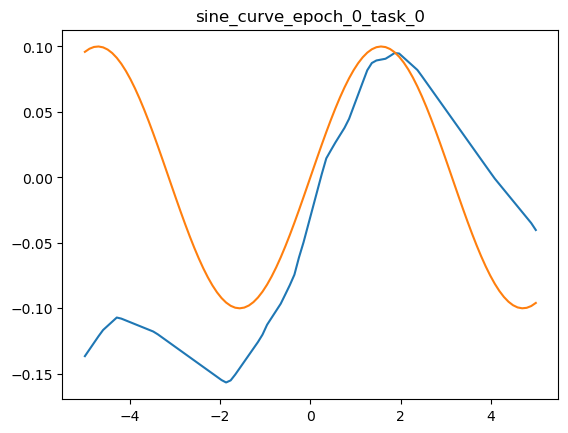

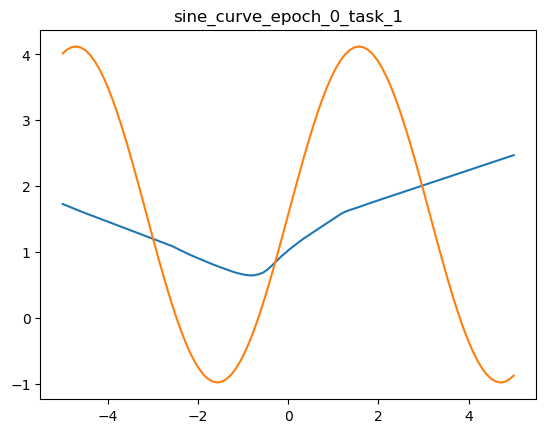

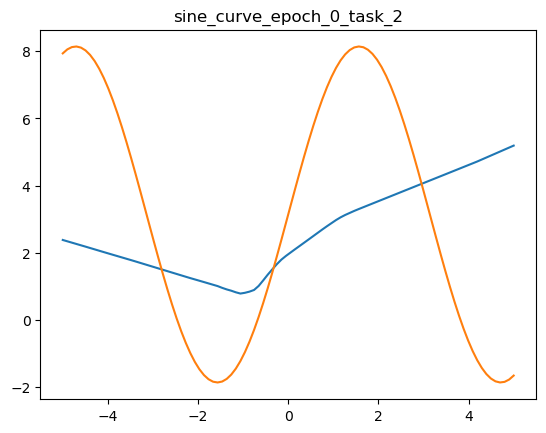

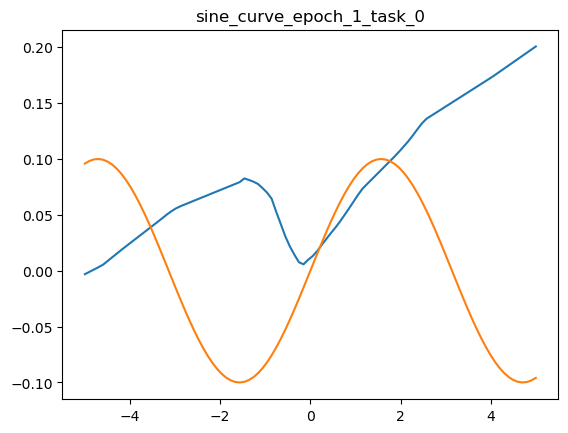

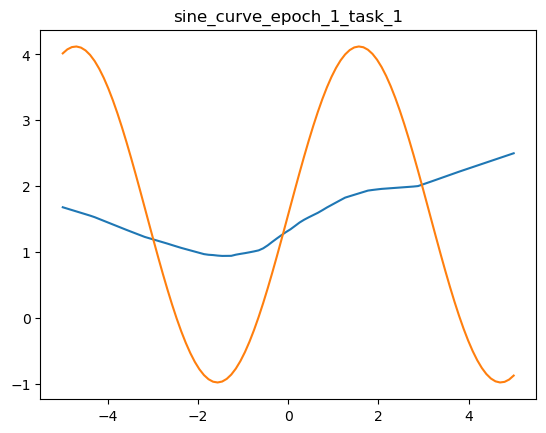

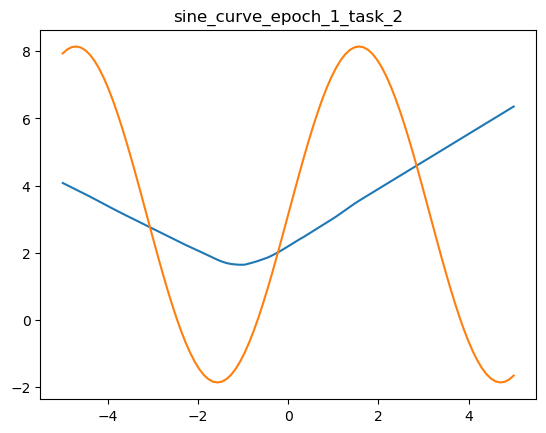

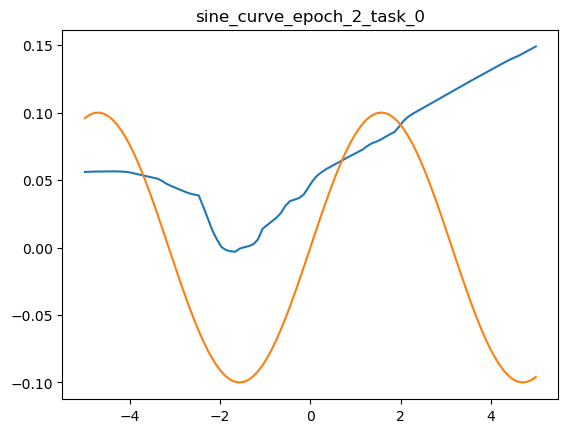

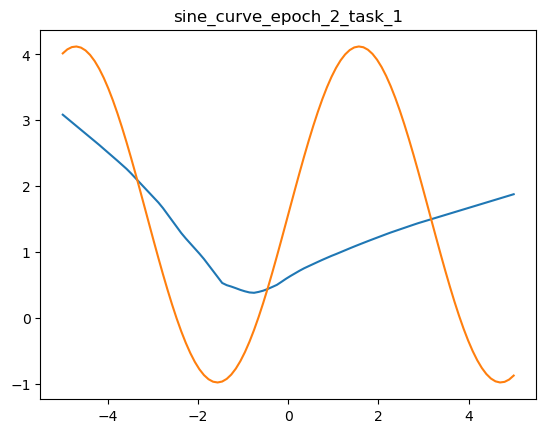

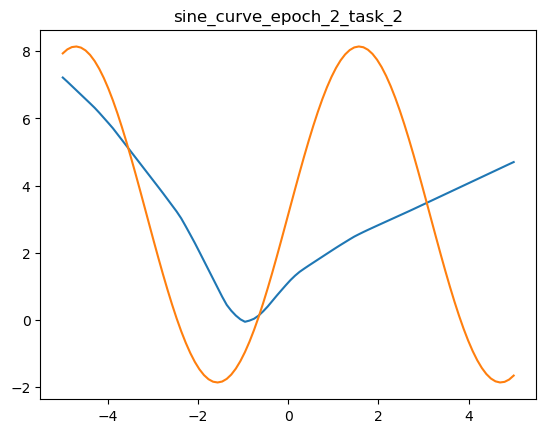

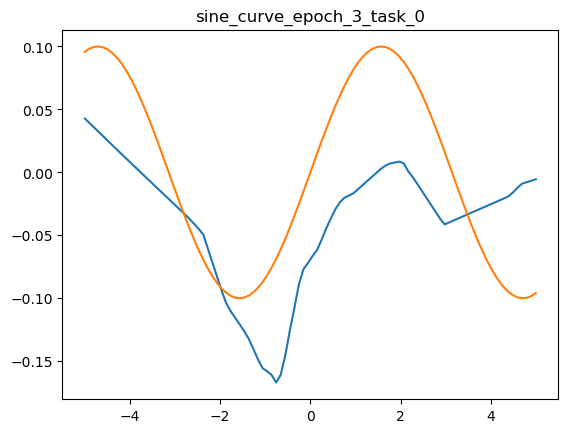

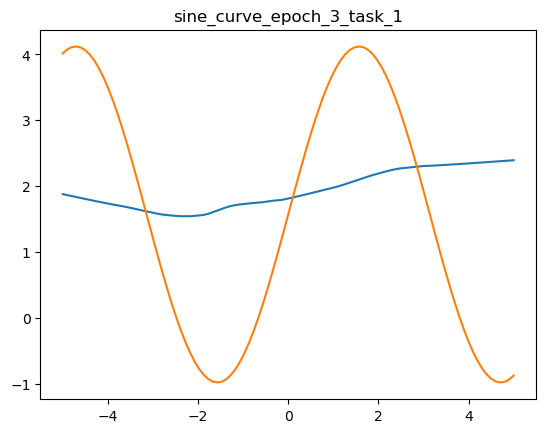

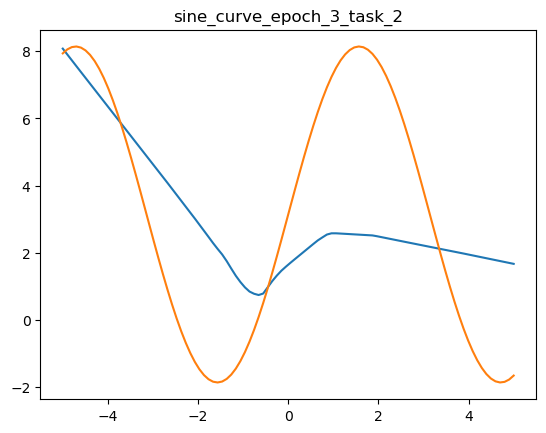

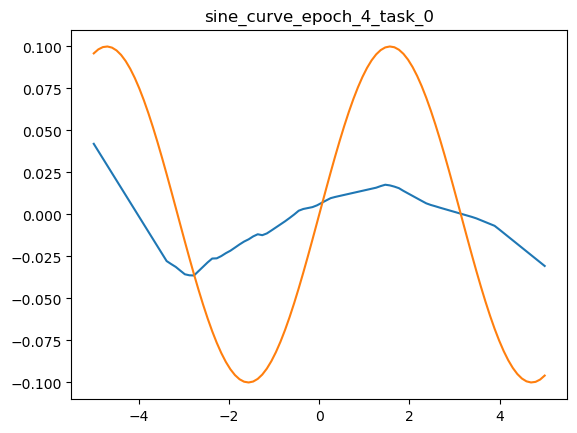

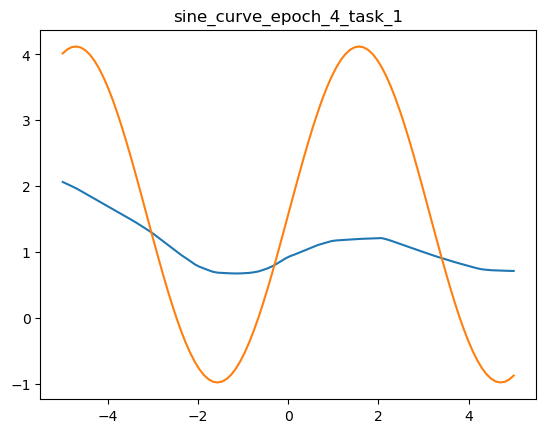

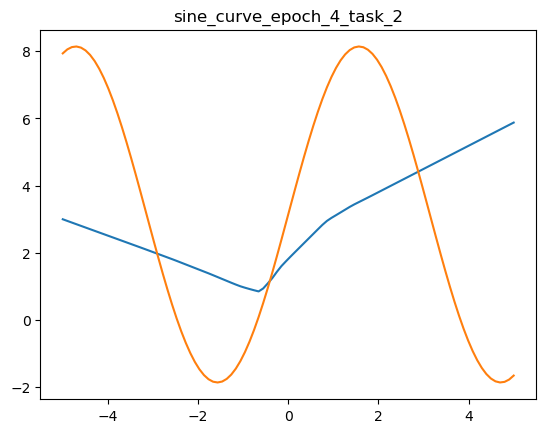

In [168]:
model.train()

In [ ]:
# 5 tasks - observe (1) reduction in loss over epochs, (2) converge on TRAIN action, (3) near perfect sine curves
# vectorized envs, n_steps
# episodes
# bounded_networks -> (1) bounded_continuous_3action, (2) bounded_episodic_1action

### Loss w/ transfer vs. w/o transfer

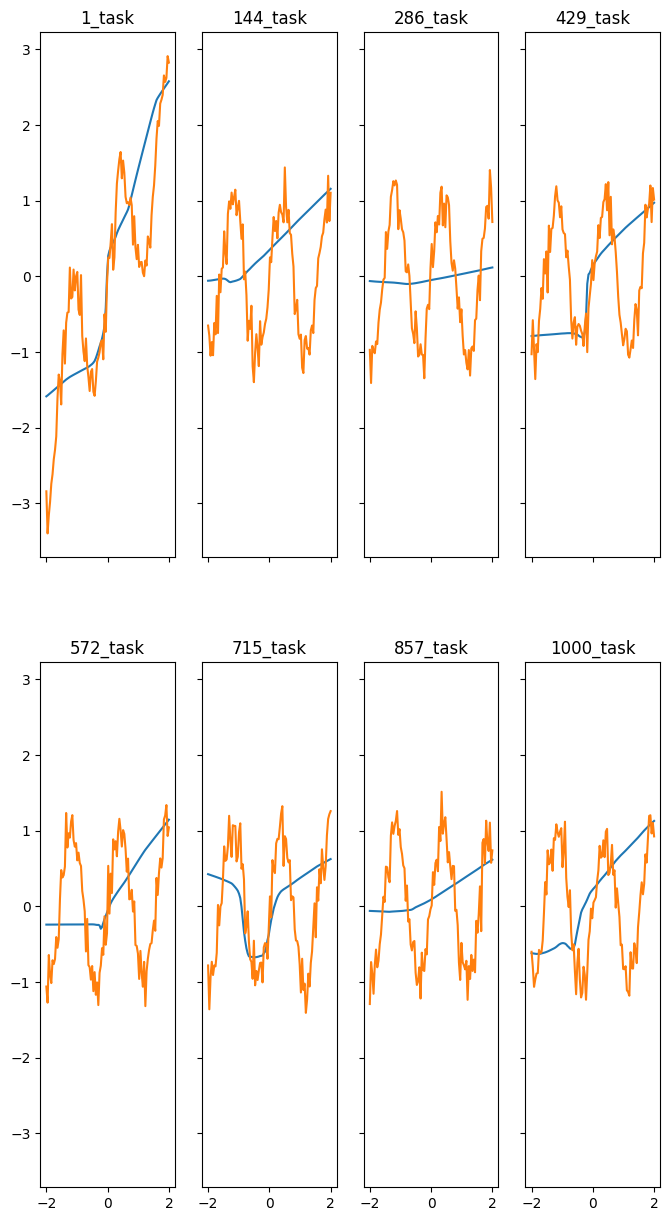

In [74]:
# PRINT PLOTS
rows = 2
cols = 4
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(8,15))
k = 0
for i in range(rows):
    for j in range(cols):
        task = list(task_to_yhats.keys())[k]
        y_hats = task_to_yhats[task]
        axs[i, j].plot(X, [y_hat.detach().numpy() for y_hat in y_hats])
        axs[i, j].plot(X, list(tasks.items())[k][1])
        axs[i,j].set_title(task)
        k+=1